# Analysis: ESS neutron simulations

In [1]:
import h5py
import tables as tb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
import scipy.ndimage.filters as spfil

In [2]:
def read_hdf5_to_df(fname):
    """
    Reads an output HDF5 file from the Geant4 simulation into a Pandas DataFrame.
    """
    
    # Open the file and get the ntuple.
    fn = h5py.File(fname,'r')
    ntuple = fn['default_ntuples']['essn']
    
    # Fill a dictionary with the ntuple column values.
    df_values = {}
    for col in list(ntuple):

        # Only process H5 groups with actual data.
        if(isinstance(ntuple[col],h5py._hl.group.Group)):
            #print("Adding column",col,"...")
            if(ntuple[col]['pages'].dtype == object):
                df_values[col] = [x.decode('utf-8') for x in ntuple[col]['pages'][:]]
            else:
                df_values[col] = ntuple[col]['pages'][:]
             
    # Create the dataframe.
    df = pd.DataFrame.from_dict(df_values)
    
    # Add composite columns.
    ri = (df.xi**2 + df.yi**2 + df.zi**2)**0.5
    rf = (df.xf**2 + df.yf**2 + df.zf**2)**0.5
    Ki = (df.pxi**2 + df.pyi**2 + df.pzi**2 + df.mass**2)**0.5 - df.mass
    Kf = (df.pxf**2 + df.pyf**2 + df.pzf**2 + df.mass**2)**0.5 - df.mass
    
    df['ri'] = ri  # initial radius
    df['rf'] = rf  # final radius
    df['Ki'] = Ki  # initial kinetic energy
    df['Kf'] = Kf  # final kinetic energy
    
    return df

def read_hdf5_histo(fname):
    
    fn = h5py.File(fname,'r')
    hh = fn['default_histograms']['wenergy0']

In [2]:
fn = h5py.File("/home/jrenner/local/ESS/build/essn_output.hdf5")

In [57]:
hh = np.array(fn['default_histograms']['wenergy1120']['bin_Sw2'][:])

In [53]:
fn['default_histograms']['wenergy1000']['bin_Sx2w_elem_12'][0]

0.0

In [54]:
fn['default_histograms']['wenergy1000'].keys()

<KeysViewHDF5 ['annotations_elem_0_first', 'annotations_elem_0_secon', 'annotations_size', 'axis_0_bin_width', 'axis_0_edges_size', 'axis_0_fixed', 'axis_0_maximum_value', 'axis_0_minimum_value', 'axis_0_number_of_bins', 'axis_0_offset', 'bin_Sw', 'bin_Sw2', 'bin_Sw2_size', 'bin_Sw_size', 'bin_Sx2w_elem_0', 'bin_Sx2w_elem_0_size', 'bin_Sx2w_elem_1', 'bin_Sx2w_elem_10', 'bin_Sx2w_elem_100', 'bin_Sx2w_elem_100_size', 'bin_Sx2w_elem_101', 'bin_Sx2w_elem_101_size', 'bin_Sx2w_elem_10_size', 'bin_Sx2w_elem_11', 'bin_Sx2w_elem_11_size', 'bin_Sx2w_elem_12', 'bin_Sx2w_elem_12_size', 'bin_Sx2w_elem_13', 'bin_Sx2w_elem_13_size', 'bin_Sx2w_elem_14', 'bin_Sx2w_elem_14_size', 'bin_Sx2w_elem_15', 'bin_Sx2w_elem_15_size', 'bin_Sx2w_elem_16', 'bin_Sx2w_elem_16_size', 'bin_Sx2w_elem_17', 'bin_Sx2w_elem_17_size', 'bin_Sx2w_elem_18', 'bin_Sx2w_elem_18_size', 'bin_Sx2w_elem_19', 'bin_Sx2w_elem_19_size', 'bin_Sx2w_elem_1_size', 'bin_Sx2w_elem_2', 'bin_Sx2w_elem_20', 'bin_Sx2w_elem_20_size', 'bin_Sx2w_elem_2

In [58]:
hh

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Read in the ntuple

In [ ]:
!wget https://www.dropbox.com/s/vlxnyp6671qvg0z/essn_ntuple.hdf5

In [ ]:
#df = read_hdf5_to_df('/home/jrenner/local/ESS/build/essn_ntuple.hdf5')
df = read_hdf5_to_df('/home/jrenner/Dropbox/ESS/data/essn_ntuple.hdf5')
df.head()

In [ ]:
np.unique(df.event)

In [ ]:
plt.hist(df.zi[(df.zi > -100) & (df.zi < 100)],bins=100)

### Analysis: neutron energies

In [ ]:
# Select gamma events that made it out of the target.
df_neutrons_world = df[(df.particleName == 'neutron') & (df.volFinal == 'World')]
Nprotons = len(np.unique(df.event))

In [ ]:
plt.hist(np.log10(df_neutrons_world.Kf),weights=(1/Nprotons)*np.ones_like(df_neutrons_world.Kf),bins=100,histtype='step',fill=False)
#plt.hist(df_neutrons_world.Kf,weights=(1/Nprotons)*np.ones_like(df_neutrons_world.Kf),bins=np.logspace(np.log10(0.1),np.log10(5000), 200))
plt.xlabel('log$_{10}$(E(MeV))')
plt.ylabel('neutrons/proton/dlog$_{10}$(E)')
#plt.xscale("log")
plt.yscale("log")

### Analysis: weight windows

In [3]:
def read_weights_file(fname, xCells, yCells, zCells):
    
    results = pd.read_csv(fname,delimiter=' ',index_col=0,header=None)
    cell_nums = results.index.values
    weights = results[1].values
    errors = results[2].values

    wmatrix = np.zeros([xCells,yCells,zCells])
    ematrix = np.zeros([xCells,yCells,zCells])
    for cell_num, weight, error in zip(cell_nums, weights, errors):
        i = int(cell_num / (yCells*zCells))
        j = int(cell_num / zCells) % yCells
        k = cell_num % zCells

        wmatrix[i][j][k] = weight
        ematrix[i][j][k] = error
        
    return wmatrix, ematrix

In [4]:
worldX, worldY, worldZ = 1200, 1200, 160
xCells, yCells, zCells = 31, 31, 5

BoxX = worldX/xCells/2.0
BoxY = worldY/yCells/2.0
BoxZ = worldZ/zCells/2.0

startx = -worldX/2.0 + BoxX
starty = -worldY/2.0 + BoxY
startz = -worldZ/2.0 + BoxZ

ri_shield = 245
ri_concrete = 550
rf_concrete = 600

##### Compare flux/max_flux

In [ ]:
wmatrix_pre, ematrix_pre = read_weights_file("/home/jrenner/local/ESS/results/run3/pre/Results_-1.txt", xCells, yCells, zCells)
wmatrix_it1, ematrix_it1 = read_weights_file("/home/jrenner/local/ESS/results/run3/it1_1000/Results_-1.txt", xCells, yCells, zCells)
maxval_pre = np.max(wmatrix_pre)
maxval_it1 = np.max(wmatrix_it1)

In [ ]:
iz = 2 #np.argmax(np.sum(wmatrix,axis=(0,1)))
fig = plt.figure()
fig.set_figheight(12.0)
fig.set_figwidth(18.0)

mmatrix_pre = wmatrix_pre[:,:,iz]
minval_pre = np.min(mmatrix_pre[mmatrix_pre > 0])

mmatrix_it1 = wmatrix_it1[:,:,iz]
minval_it1 = np.min(mmatrix_it1[mmatrix_it1 > 0])

ax1 = fig.add_subplot(221, aspect='auto')
im1 = ax1.imshow(np.log(wmatrix_pre[:,:,iz]/maxval_pre + minval_pre/maxval_pre/10.).transpose(),
            extent=[-worldX/2.0 + BoxX,worldX/2.0 + BoxX,-worldY/2.0 + BoxY,worldY/2.0 + BoxY], 
            origin = 'lower',
            interpolation = "none")
e1c = patches.Ellipse((0, 0), ri_concrete*2, ri_concrete*2,
                     linewidth=2, fill=False, color='white')
e1s = patches.Ellipse((0, 0), ri_shield*2, ri_shield*2,
                     linewidth=2, fill=False, color='blue')
ax1.add_patch(e1c)
ax1.add_patch(e1s)
ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
cbar1 = fig.colorbar(im1)
cbar1.set_label("log(N)", rotation=270)

ax2 = fig.add_subplot(222, aspect='auto')
im2 = ax2.imshow(ematrix_pre[:,:,iz].transpose(),
            extent=[-worldX/2.0 + BoxX,worldX/2.0 + BoxX,-worldY/2.0 + BoxY,worldY/2.0 + BoxY], 
            origin = 'lower',
            interpolation = "none")
e2c = patches.Ellipse((0, 0), ri_concrete*2, ri_concrete*2,
                     linewidth=2, fill=False, color='white')
e2s = patches.Ellipse((0, 0), ri_shield*2, ri_shield*2,
                     linewidth=2, fill=False, color='blue')
ax2.add_patch(e2c)
ax2.add_patch(e2s)
ax2.set_xlabel("x (cm)")
ax2.set_ylabel("y (cm)")
cbar2 = fig.colorbar(im2)
cbar2.set_label("error", rotation=270)

ax3 = fig.add_subplot(223, aspect='auto')
im3 = ax3.imshow(np.log(wmatrix_it1[:,:,iz]/maxval_it1 + minval_it1/maxval_it1/10.).transpose(),
            extent=[-worldX/2.0 + BoxX,worldX/2.0 + BoxX,-worldY/2.0 + BoxY,worldY/2.0 + BoxY], 
            origin = 'lower',
            interpolation = "none")
e3c = patches.Ellipse((0, 0), ri_concrete*2, ri_concrete*2,
                     linewidth=2, fill=False, color='white')
e3s = patches.Ellipse((0, 0), ri_shield*2, ri_shield*2,
                     linewidth=2, fill=False, color='blue')
ax3.add_patch(e3c)
ax3.add_patch(e3s)
ax3.set_xlabel("x (cm)")
ax3.set_ylabel("y (cm)")
cbar3 = fig.colorbar(im3)
cbar3.set_label("log(N)", rotation=270)

ax4 = fig.add_subplot(224, aspect='auto')
im4 = ax4.imshow(ematrix_it1[:,:,iz].transpose(),
            extent=[-worldX/2.0 + BoxX,worldX/2.0 + BoxX,-worldY/2.0 + BoxY,worldY/2.0 + BoxY], 
            origin = 'lower',
            interpolation = "none")
e4c = patches.Ellipse((0, 0), ri_concrete*2, ri_concrete*2,
                     linewidth=2, fill=False, color='white')
e4s = patches.Ellipse((0, 0), ri_shield*2, ri_shield*2,
                     linewidth=2, fill=False, color='blue')
ax4.add_patch(e4c)
ax4.add_patch(e4s)
ax4.set_xlabel("x (cm)")
ax4.set_ylabel("y (cm)")
cbar4 = fig.colorbar(im4)
cbar4.set_label("error", rotation=270)

In [ ]:
# Create a new matrix with flux/max_flux values from the matrix with the smallest error at each location.
wmatrix_new = np.zeros([xCells,yCells,zCells])
ematrix_new = np.zeros([xCells,yCells,zCells])

wmatrix_new[(ematrix_pre < ematrix_it1)]  = wmatrix_pre[ematrix_pre < ematrix_it1]/maxval_pre
ematrix_new[(ematrix_pre < ematrix_it1)]  = ematrix_pre[ematrix_pre < ematrix_it1]

wmatrix_new[(ematrix_pre >= ematrix_it1) | (ematrix_pre == 0)] = wmatrix_it1[(ematrix_pre >= ematrix_it1) | (ematrix_pre == 0)]/maxval_it1
ematrix_new[(ematrix_pre >= ematrix_it1) | (ematrix_pre == 0)] = ematrix_it1[(ematrix_pre >= ematrix_it1) | (ematrix_pre == 0)]

In [ ]:
# Examine the new flux matrix.
iz = 2 #np.argmax(np.sum(wmatrix,axis=(0,1)))
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(18.0)

maxval_new = np.max(wmatrix_new)
mmatrix_new = wmatrix_new[:,:,iz]
minval_new = np.min(mmatrix_new[mmatrix_new > 0])

ax1 = fig.add_subplot(121, aspect='auto')
im1 = ax1.imshow(np.log(wmatrix_new[:,:,iz]/maxval_new + minval_new/maxval_new/10.).transpose(),
            extent=[-worldX/2.0 + BoxX,worldX/2.0 + BoxX,-worldY/2.0 + BoxY,worldY/2.0 + BoxY], 
            origin = 'lower',
            interpolation = "none")
e1c = patches.Ellipse((0, 0), ri_concrete*2, ri_concrete*2,
                     linewidth=2, fill=False, color='white')
e1s = patches.Ellipse((0, 0), ri_shield*2, ri_shield*2,
                     linewidth=2, fill=False, color='blue')
ax1.add_patch(e1c)
ax1.add_patch(e1s)
ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
cbar1 = fig.colorbar(im1)
cbar1.set_label("log(N)", rotation=270)

ax2 = fig.add_subplot(122, aspect='auto')
im2 = ax2.imshow(ematrix_new[:,:,iz].transpose(),
            extent=[-worldX/2.0 + BoxX,worldX/2.0 + BoxX,-worldY/2.0 + BoxY,worldY/2.0 + BoxY], 
            origin = 'lower',
            interpolation = "none")
e2c = patches.Ellipse((0, 0), ri_concrete*2, ri_concrete*2,
                     linewidth=2, fill=False, color='white')
e2s = patches.Ellipse((0, 0), ri_shield*2, ri_shield*2,
                     linewidth=2, fill=False, color='blue')
ax2.add_patch(e2c)
ax2.add_patch(e2s)
ax2.set_xlabel("x (cm)")
ax2.set_ylabel("y (cm)")
cbar2 = fig.colorbar(im2)
cbar2.set_label("error", rotation=270)

In [ ]:
# Write out the new matrix
with open('matrix.dat','w') as f:
    for icell,(wm,em) in enumerate(zip(wmatrix_new.flatten(),ematrix_new.flatten())):
        if(wm == 0): wm = int(wm)
        if(em == 0): em = int(em)
        f.write("{} {} {}\n".format(icell,wm,em))

##### Compare several matrices

In [ ]:
#wmatrix_pre, ematrix_pre = read_weights_file("/home/jrenner/local/ESS/results/run3/pre/Results_-1.txt", xCells, yCells, zCells)
wmatrix_pre, ematrix_pre = read_weights_file("/home/jrenner/local/ESS/build/Results_-1.txt", xCells, yCells, zCells)
wmatrix_it1, ematrix_it1 = read_weights_file("/home/jrenner/local/ESS/results/run3/it1_1000/Results_-1.txt", xCells, yCells, zCells)
wmatrix_it2, ematrix_it2 = read_weights_file("/home/jrenner/local/ESS/results/run3/it2_100/Results_-1.txt", xCells, yCells, zCells)

In [ ]:
# Consider projections on the y-axis.
Nevents_pre = 200000
Nevents_it1 = 1000
Nevents_it2 = 100

norm_pre = np.sum(wmatrix_pre)
norm_it1 = np.sum(wmatrix_it1)
norm_it2 = np.sum(wmatrix_it2)
print("Matrix norms:\npre =",norm_pre,"\nit1 = ",norm_it1,"\nit2 = ",norm_it2,"\nratio pre/it1 = ",norm_pre/norm_it1,"\nratio pre/it2 = ",norm_pre/norm_it2)

ematrix_pre[ematrix_pre == 0] = np.nan
ematrix_it1[ematrix_it1 == 0] = np.nan

yproj_pre = np.mean(wmatrix_pre/Nevents_pre,axis=(0,2))
yproj_it1 = np.mean(wmatrix_it1/Nevents_it1,axis=(0,2))
yproj_pre_err = np.nanmean(ematrix_pre*(wmatrix_pre/Nevents_pre),axis=(0,2))
yproj_it1_err = np.nanmean(ematrix_it1*(wmatrix_it1/Nevents_it1),axis=(0,2))
yvals = np.linspace(-worldY/2, worldY/2, len(yproj_pre))
plt.errorbar(yvals,yproj_pre,yerr=yproj_pre_err)
plt.errorbar(yvals,yproj_it1,yerr=yproj_it1_err)
#plt.xlim([-300,300])
plt.ylim([0,0.2])
#plt.yscale("log")
# print("yvals",len(yvals),"matrix",len(yproj_pre))
# print(np.nanmean(ematrix_pre,axis=(0,2)))
# print(np.nanmean(wmatrix_pre/Nevents_pre,axis=(0,2)))

In [ ]:
plt.plot(yvals,np.nanmean(ematrix_it1,axis=(0,2)))

##### Plot a single matrix

In [5]:
wmatrix, ematrix = read_weights_file("/home/jrenner/local/ESS/results/run5/pre_200k/Results_-1.txt", xCells, yCells, zCells)

/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


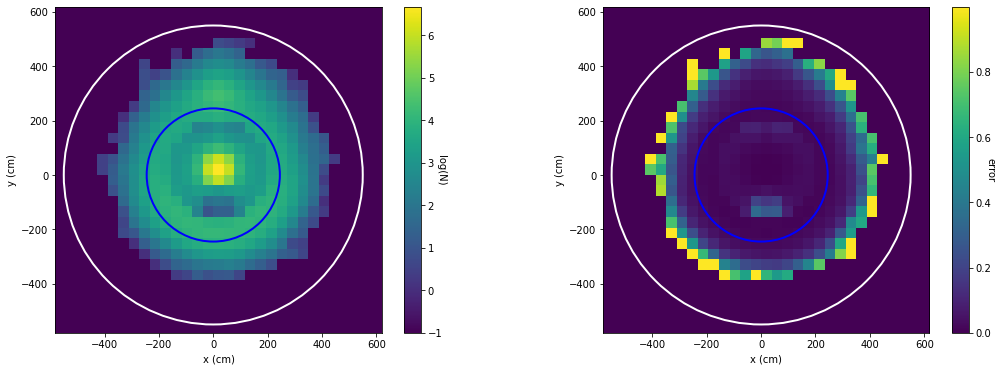

In [6]:
iz = 3 #np.argmax(np.sum(wmatrix,axis=(0,1)))
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(18.0)

mmatrix = wmatrix[:,:,iz]
minval = np.min(mmatrix[mmatrix > 0])
cutmatrix = np.zeros(mmatrix.shape)
cut = np.abs((1./mmatrix) - 2.5024e9) < 1e8
cutmatrix[cut] = mmatrix[cut]

ax1 = fig.add_subplot(121, aspect='auto')
im1 = ax1.imshow(np.log10(mmatrix + minval/10.).transpose(),
            extent=[-worldX/2.0 + BoxX,worldX/2.0 + BoxX,-worldY/2.0 + BoxY,worldY/2.0 + BoxY], 
            origin = 'lower',
            interpolation = "none")
e1c = patches.Ellipse((0, 0), ri_concrete*2, ri_concrete*2,
                     linewidth=2, fill=False, color='white')
e1s = patches.Ellipse((0, 0), ri_shield*2, ri_shield*2,
                     linewidth=2, fill=False, color='blue')
ax1.add_patch(e1c)
ax1.add_patch(e1s)
ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
cbar1 = fig.colorbar(im1)
cbar1.set_label("log(N)", rotation=270)

ax2 = fig.add_subplot(122, aspect='auto')
im2 = ax2.imshow(ematrix[:,:,iz].transpose(),
            extent=[-worldX/2.0 + BoxX,worldX/2.0 + BoxX,-worldY/2.0 + BoxY,worldY/2.0 + BoxY], 
            origin = 'lower',
            interpolation = "none")
e2c = patches.Ellipse((0, 0), ri_concrete*2, ri_concrete*2,
                     linewidth=2, fill=False, color='white')
e2s = patches.Ellipse((0, 0), ri_shield*2, ri_shield*2,
                     linewidth=2, fill=False, color='blue')
ax2.add_patch(e2c)
ax2.add_patch(e2s)
ax2.set_xlabel("x (cm)")
ax2.set_ylabel("y (cm)")
cbar2 = fig.colorbar(im2)
cbar2.set_label("error", rotation=270)
#ax2.set_title("Thread-safe")

##### Smooth the distribution

In [ ]:
wsmoothed = spfil.gaussian_filter(wmatrix,1.0)
iz = np.argmax(np.sum(wsmoothed,axis=(0,1)))
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(18.0)

mmatrix = wsmoothed[:,:,iz]
minval = np.min(wsmoothed[mmatrix > 0])

ax1 = fig.add_subplot(121, aspect='auto')
im1 = ax1.imshow(np.log(wsmoothed[:,:,iz] + minval/10.).transpose(),
            extent=[-worldX/2.0 + BoxX,worldX/2.0 + BoxX,-worldY/2.0 + BoxY,worldY/2.0 + BoxY], 
            origin = 'lower',
            interpolation = "none")

e1c = patches.Ellipse((0, 0), ri_concrete*2, ri_concrete*2,
                     linewidth=2, fill=False, color='white')
e1s = patches.Ellipse((0, 0), ri_shield*2, ri_shield*2,
                     linewidth=2, fill=False, color='blue')
ax1.add_patch(e1c)
ax1.add_patch(e1s)
ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
cbar1 = fig.colorbar(im1)
cbar1.set_label("log(N)", rotation=270)

##### Write out the smoothed matrix

In [ ]:
with open('matrix_pre.dat','w') as f:
    for icell,(wm,em) in enumerate(zip(wsmoothed.flatten(),ematrix.flatten())):
        if(wm == 0): wm = int(wm)
        if(em == 0): em = int(em)
        f.write("{} {} {}\n".format(icell,wm,em))

### Look at a single projection

In [ ]:
#yproj = np.sum(wmatrix,axis=(0,2))
#plt.plot(yproj,'.')

In [ ]:
plt.plot(np.sum(wmatrix,axis=(0,1)))
plt.xlabel("z-plane number")
plt.ylabel("Summed counts")
# iz = np.argmax(np.sum(wmatrix,axis=(0,1))) # index of chosen z-plane

## Misc. code

In [ ]:
iz = np.argmax(np.sum(wmatrix,axis=(0,1)))
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

mmatrix = wmatrix[:,:,iz]
minval = np.min(mmatrix[mmatrix > 0])

ax1 = fig.add_subplot(131, aspect='auto')
im1 = ax1.imshow(np.log(wmatrix[:,:,iz] + minval/10.).transpose(),
            extent=[-worldX/2.0 + BoxX,worldX/2.0 + BoxX,-worldY/2.0 + BoxY,worldY/2.0 + BoxY], 
            origin = 'lower',
            interpolation = "none")
e1c = patches.Ellipse((0, 0), ri_concrete*2, ri_concrete*2,
                     linewidth=2, fill=False, color='white')
e1s = patches.Ellipse((0, 0), ri_shield*2, ri_shield*2,
                     linewidth=2, fill=False, color='blue')
ax1.add_patch(e1c)
ax1.add_patch(e1s)
ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
cbar1 = fig.colorbar(im1)
cbar1.set_label("log(N)", rotation=270)

ax2 = fig.add_subplot(132, aspect='auto')
im2 = ax2.imshow(ematrix[:,:,iz].transpose(),
            extent=[-worldX/2.0 + BoxX,worldX/2.0 + BoxX,-worldY/2.0 + BoxY,worldY/2.0 + BoxY], 
            origin = 'lower',
            interpolation = "none")
e2c = patches.Ellipse((0, 0), ri_concrete*2, ri_concrete*2,
                     linewidth=2, fill=False, color='white')
e2s = patches.Ellipse((0, 0), ri_shield*2, ri_shield*2,
                     linewidth=2, fill=False, color='blue')
ax2.add_patch(e2c)
ax2.add_patch(e2s)
ax2.set_xlabel("x (cm)")
ax2.set_ylabel("y (cm)")
cbar2 = fig.colorbar(im2)
cbar2.set_label("error", rotation=270)
ax2.set_title("Thread-safe")

ax3 = fig.add_subplot(133, aspect='auto')
im3 = ax3.imshow(ematrix2[:,:,iz].transpose(),
            extent=[-worldX/2.0 + BoxX,worldX/2.0 + BoxX,-worldY/2.0 + BoxY,worldY/2.0 + BoxY], 
            origin = 'lower',
            interpolation = "none")
e3c = patches.Ellipse((0, 0), ri_concrete*2, ri_concrete*2,
                     linewidth=2, fill=False, color='white')
e3s = patches.Ellipse((0, 0), ri_shield*2, ri_shield*2,
                     linewidth=2, fill=False, color='blue')
ax3.add_patch(e3c)
ax3.add_patch(e3s)
ax3.set_xlabel("x (cm)")
ax3.set_ylabel("y (cm)")
cbar3 = fig.colorbar(im3)
cbar3.set_label("error", rotation=270)
ax3.set_title("Original method")